In [ ]:
!pip install scikit-posthocs

# Avaliação estatistica

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# === 1. Carregar os arquivos CSV ===

gridsearch_paths = {
    "in_vivo_descritores": "gridsearch_resultados_vivo_descritores.csv",
    "in_vivo_vector": "resultados_gridsearch_w2v_vivo.csv",
    "in_vivo_v&d": "resultados_gridsearch_V&D_vivo.csv",
    "in_vitro_descritores": "gridsearch_resultados_vitro_descritores.csv",
    "in_vitro_vector": "resultados_gridsearch_w2v_vitro.csv",
    "in_vitro_v&d": "resultados_gridsearch_V&D_vitro.csv",
    "combinado_descritores": "gridsearch_resultados_both_descritores.csv",
    "combinado_vector": "resultados_gridsearch_w2v_conjunto.csv",
    "combinado_v&d": "resultados_gridsearch_V&D_both.csv"
}

# Carregar arquivos em um dicionário de DataFrames
grid_dfs = {name: pd.read_csv(path) for name, path in gridsearch_paths.items()}

# === 2. Extrair a melhor combinação (maior F1) de cada configuração ===

def extrair_melhor(df, dataset, representacao):
    idx_max_f1 = df["mean_test_f1"].idxmax()
    melhor = df.loc[idx_max_f1].copy()
    melhor["Dataset"] = dataset
    melhor["Representação"] = representacao
    return melhor

melhores_gridsearch = pd.DataFrame([
    extrair_melhor(grid_dfs["in_vivo_descritores"], "In Vivo", "Descritores"),
    extrair_melhor(grid_dfs["in_vivo_vector"], "In Vivo", "Word2Vec"),
    extrair_melhor(grid_dfs["in_vivo_v&d"], "In Vivo", "Combinação"),
    extrair_melhor(grid_dfs["in_vitro_descritores"], "In Vitro", "Descritores"),
    extrair_melhor(grid_dfs["in_vitro_vector"], "In Vitro", "Word2Vec"),
    extrair_melhor(grid_dfs["in_vitro_v&d"], "In Vitro", "Combinação"),
    extrair_melhor(grid_dfs["combinado_descritores"], "Combinado", "Descritores"),
    extrair_melhor(grid_dfs["combinado_vector"], "Combinado", "Word2Vec"),
    extrair_melhor(grid_dfs["combinado_v&d"], "Combinado", "Combinação"),
])

# === 3. Simular folds para F1 e Precisão ===

simulados = []
for _, row in melhores_gridsearch.iterrows():
    for metrica in [("f1", "mean_test_f1", "std_test_f1"), ("precisao", "mean_test_precision", "std_test_precision")]:
        nome_col, media_col, std_col = metrica
        media = row[media_col]
        std = row[std_col] if not np.isnan(row[std_col]) else 0.0
        simulacoes = np.random.normal(loc=media, scale=std, size=10)
        for valor in simulacoes:
            simulados.append({
                "valor": valor,
                "Métrica": nome_col,
                "Dataset": row["Dataset"],
                "Representação": row["Representação"]
            })

df_simulado = pd.DataFrame(simulados)

In [10]:
# === 4. ANOVA para F1-score e Precisão por conjunto ===

print("=== ANOVA por Dataset e Métrica ===")
for metrica in df_simulado["Métrica"].unique():
    print(f"\n--- {metrica.upper()} ---")
    for dataset in df_simulado["Dataset"].unique():
        dados = df_simulado[(df_simulado["Dataset"] == dataset) & (df_simulado["Métrica"] == metrica)]
        grupos = [grupo["valor"].values for _, grupo in dados.groupby("Representação")]
        stat, pval = f_oneway(*grupos)
        print(f"{dataset}: F = {stat:.3f}, p-valor = {pval:.5f}")

=== ANOVA por Dataset e Métrica ===

--- F1 ---
In Vivo: F = 13.405, p-valor = 0.00009
In Vitro: F = 9.671, p-valor = 0.00068
Combinado: F = 15.121, p-valor = 0.00004

--- PRECISAO ---
In Vivo: F = 2.685, p-valor = 0.08641
In Vitro: F = 20.808, p-valor = 0.00000
Combinado: F = 5.374, p-valor = 0.01084


In [17]:
# === 5. Teste post-hoc de Tukey HSD separado para F1-score e Precisão ===

for metrica in ["f1"]:
    print(f"\n=== Teste de Tukey HSD para {metrica.upper()} ===")

    dados_metrica = df_simulado[df_simulado["Métrica"] == metrica]

    tukey = pairwise_tukeyhsd(
        endog=dados_metrica["valor"],
        groups=dados_metrica["Dataset"] + " - " + dados_metrica["Representação"],
        alpha=0.05
    )

    print(tukey.summary())


=== Teste de Tukey HSD para F1 ===
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
         group1                  group2         meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------
 Combinado - Combinação Combinado - Descritores  -0.0337    0.0 -0.0533 -0.0142   True
 Combinado - Combinação    Combinado - Word2Vec  -0.0374    0.0  -0.057 -0.0178   True
 Combinado - Combinação   In Vitro - Combinação   0.0474    0.0  0.0278   0.067   True
 Combinado - Combinação  In Vitro - Descritores   0.0382    0.0  0.0186  0.0577   True
 Combinado - Combinação     In Vitro - Word2Vec   0.0208 0.0283  0.0013  0.0404   True
 Combinado - Combinação    In Vivo - Combinação   -0.051    0.0 -0.0705 -0.0314   True
 Combinado - Combinação   In Vivo - Descritores   -0.072    0.0 -0.0916 -0.0524   True
 Combinado - Combinação      In Vivo - Word2Vec  -0.0692    0.0 -0.0888 -0.0496   True
Combina

In [18]:
# === 5. Teste post-hoc de Tukey HSD separado para F1-score e Precisão ===

for metrica in ["precisao"]:
    print(f"\n=== Teste de Tukey HSD para {metrica.upper()} ===")

    dados_metrica = df_simulado[df_simulado["Métrica"] == metrica]

    tukey = pairwise_tukeyhsd(
        endog=dados_metrica["valor"],
        groups=dados_metrica["Dataset"] + " - " + dados_metrica["Representação"],
        alpha=0.05
    )

    print(tukey.summary())



=== Teste de Tukey HSD para PRECISAO ===
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
         group1                  group2         meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------
 Combinado - Combinação Combinado - Descritores  -0.0331 0.0714 -0.0677  0.0015  False
 Combinado - Combinação    Combinado - Word2Vec  -0.0276 0.2281 -0.0622   0.007  False
 Combinado - Combinação   In Vitro - Combinação   0.0352 0.0429  0.0006  0.0698   True
 Combinado - Combinação  In Vitro - Descritores  -0.0214 0.5687  -0.056  0.0132  False
 Combinado - Combinação     In Vitro - Word2Vec   0.0143 0.9238 -0.0203  0.0489  False
 Combinado - Combinação    In Vivo - Combinação   0.0277 0.2242 -0.0069  0.0623  False
 Combinado - Combinação   In Vivo - Descritores  -0.0003    1.0 -0.0349  0.0344  False
 Combinado - Combinação      In Vivo - Word2Vec   0.0067 0.9995 -0.0279  0.0413  False
C

# Graficos

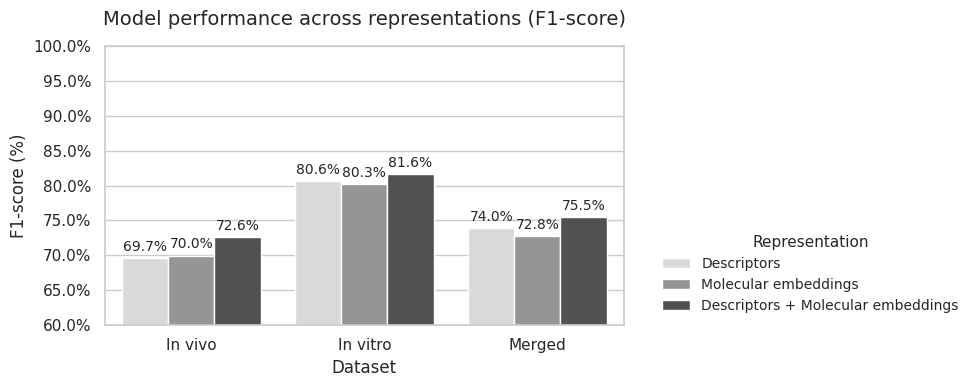

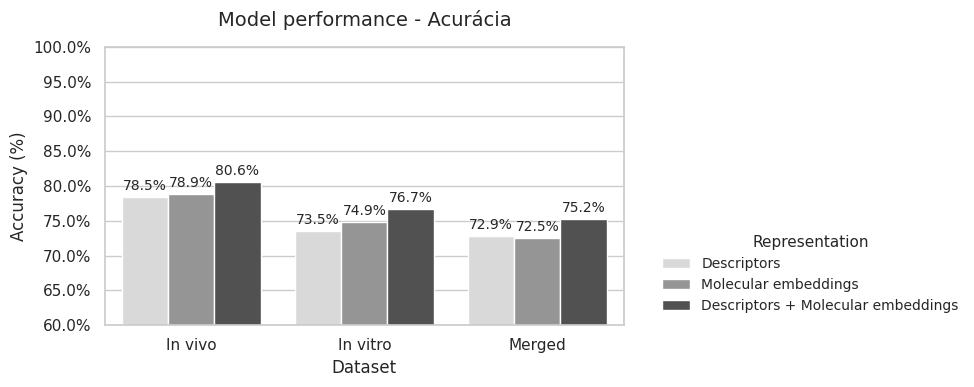

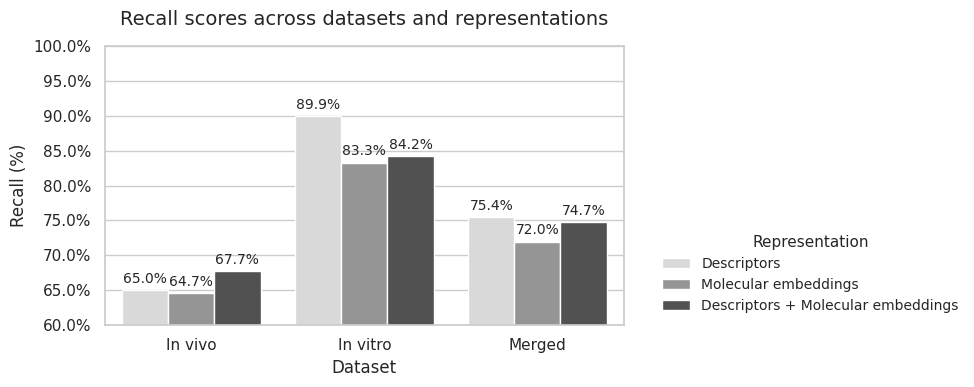

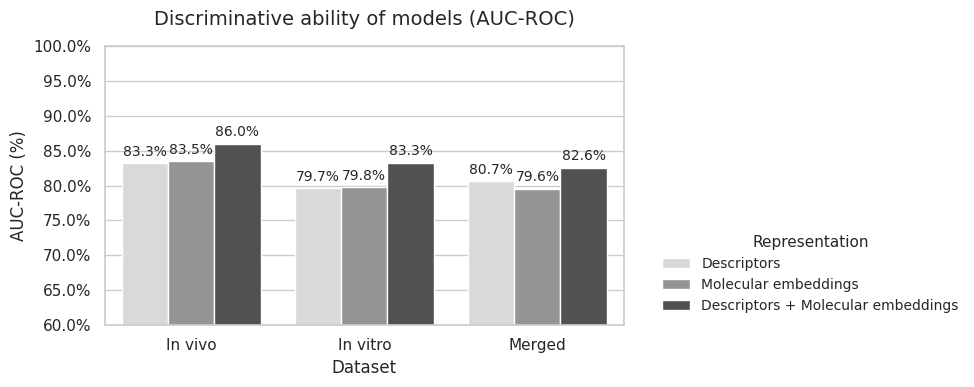

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Estilo acadêmico
sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 11})

# Caminhos dos arquivos (atualizados com os nomes dos arquivos enviados)
arquivos = {
    ("In vivo", "Descriptors"): "/content/gridsearch_resultados_vivo_descritores.csv",
    ("In vivo", "Molecular embeddings"): "/content/resultados_gridsearch_w2v_vivo.csv",
    ("In vivo", "Descriptors + Molecular embeddings"): "/content/resultados_gridsearch_V&D_vivo.csv",

    ("In vitro", "Descriptors"): "/content/gridsearch_resultados_vitro_descritores.csv",
    ("In vitro", "Molecular embeddings"): "/content/resultados_gridsearch_w2v_vitro.csv",
    ("In vitro", "Descriptors + Molecular embeddings"): "/content/resultados_gridsearch_V&D_vitro.csv",

    ("Merged", "Descriptors"): "/content/gridsearch_resultados_both_descritores.csv",
    ("Merged", "Molecular embeddings"): "/content/resultados_gridsearch_w2v_conjunto.csv",
    ("Merged", "Descriptors + Molecular embeddings"): "/content/resultados_gridsearch_V&D_both.csv"
}

# Extrair os melhores resultados
resultados = []
for (conjunto, representacao), arquivo in arquivos.items():
    df = pd.read_csv(arquivo)
    melhor = df.loc[df['mean_test_f1'].idxmax()]
    resultados.append({
        "Conjunto": conjunto,
        "Representação": representacao,
        "Modelo": melhor.get("modelo", "Modelo não especificado"),
        "F1-score": melhor["mean_test_f1"],
        "Acurácia": melhor["mean_test_accuracy"],
        "Recall": melhor["mean_test_recall"],
        "AUC-ROC": melhor["mean_test_roc_auc"]
    })

df_resultados = pd.DataFrame(resultados)

# Ordenação para os gráficos
ordem_conjuntos = ["In vivo", "In vitro", "Merged"]
ordem_representacoes = ["Descriptors", "Molecular embeddings", "Descriptors + Molecular embeddings"]

# Função de plotagem
def plot_metric(df, metric):
    titles = {
        "F1-score": "Model performance across representations (F1-score)",
        "Accuracy": "Model accuracy across datasets and representations",
        "Recall": "Recall scores across datasets and representations",
        "AUC-ROC": "Discriminative ability of models (AUC-ROC)"
    }

    plt.figure(figsize=(10, 4))
    ax = sns.barplot(
        data=df,
        x="Conjunto",
        y=metric,
        hue="Representação",
        order=ordem_conjuntos,
        hue_order=ordem_representacoes,
        palette="Greys"
    )


    plt.title(titles.get(metric, f"Model performance - {metric}"), fontsize=14, pad=15)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    # Base do gráfico em 60% para melhor visualização
    plt.ylim(0.6, 1)

    for container in ax.containers:
        ax.bar_label(
            container,
            labels=[f"{v*100:.1f}%" for v in container.datavalues],
            label_type='edge',
            fontsize=10,
            padding=3
        )

    plt.legend(
        title="Representation",
        bbox_to_anchor=(1.05, 0),
        loc="lower left",
        frameon=False,
        fontsize=10,
        title_fontsize=11
    )

    plt.ylabel("Accuracy (%)" if metric == "Acurácia" else f"{metric} (%)")
    plt.xlabel("Dataset")
    plt.tight_layout()
    plt.show()

# Gerar os gráficos para todas as métricas
for metrica in ["F1-score", "Acurácia", "Recall", "AUC-ROC"]:
    plot_metric(df_resultados, metrica)


# lazypredicts

In [31]:
# Mapear todos os arquivos com seus respectivos conjuntos e representações
file_paths = {
    ("In vivo", "Descriptors"): "/content/results_vivo_descritores_lazy.csv",
    ("In vivo", "Molecular embeddings"): "/content/results_vivo_Vector_lazy.csv",
    ("In vivo", "Descriptors + Molecular embeddings"): "/content/results_vivo_V&D_lazy.csv",

    ("In vitro", "Descriptors"): "/content/results_vitro_descritores_lazy.csv",
    ("In vitro", "Molecular embeddings"): "/content/results_vitro_Vector_lazy.csv",
    ("In vitro", "Descriptors + Molecular embeddings"): "/content/results_vitro_V&D_lazy.csv",

    ("Merged", "Descriptors"): "/content/results_both_descritores_lazy.csv",
    ("Merged", "Molecular embeddings"): "/content/results_both_Vector_lazy.csv",
    ("Merged", "Descriptors + Molecular embeddings"): "/content/results_both_V&D_lazy.csv",
}

# Função para extrair os top 5 por F1-score de cada arquivo
def get_top5_models(filepath):
    df = pd.read_csv(filepath)
    df = df[df['Unnamed: 0'].notna() & (df['Unnamed: 0'] != 'Model')]
    df = df.sort_values(by="F1 Score", ascending=False).head(5)
    df = df[['Unnamed: 0', 'Accuracy', 'F1 Score']].reset_index(drop=True)
    df.columns = ["Modelo", "Acurácia", "F1-score"]
    df["F1-score"] = pd.to_numeric(df["F1-score"])
    df["Acurácia"] = pd.to_numeric(df["Acurácia"])
    return df

# Coletar todos os top 5
top5_results = []
for (dataset, rep), path in file_paths.items():
    df = get_top5_models(path)
    df["Conjunto"] = dataset
    df["Representação"] = rep
    top5_results.append(df)

# Concatenar todos os resultados
df_top5_all = pd.concat(top5_results, ignore_index=True)


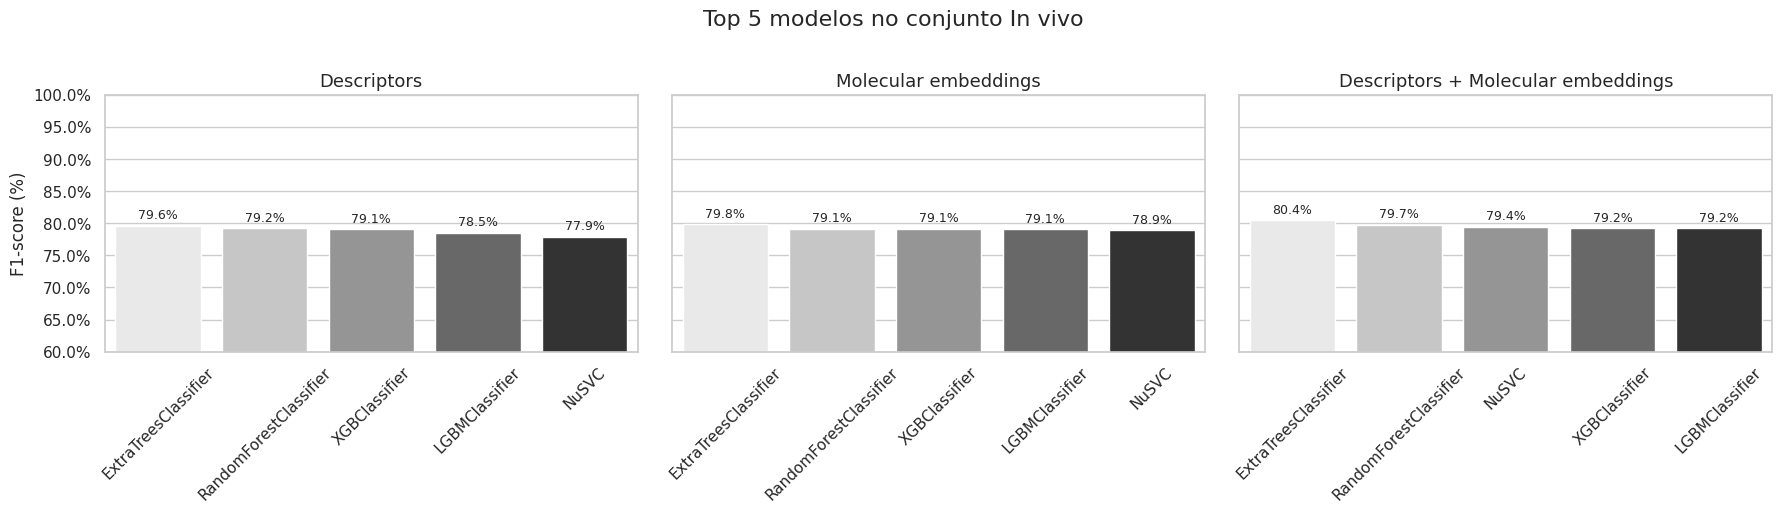

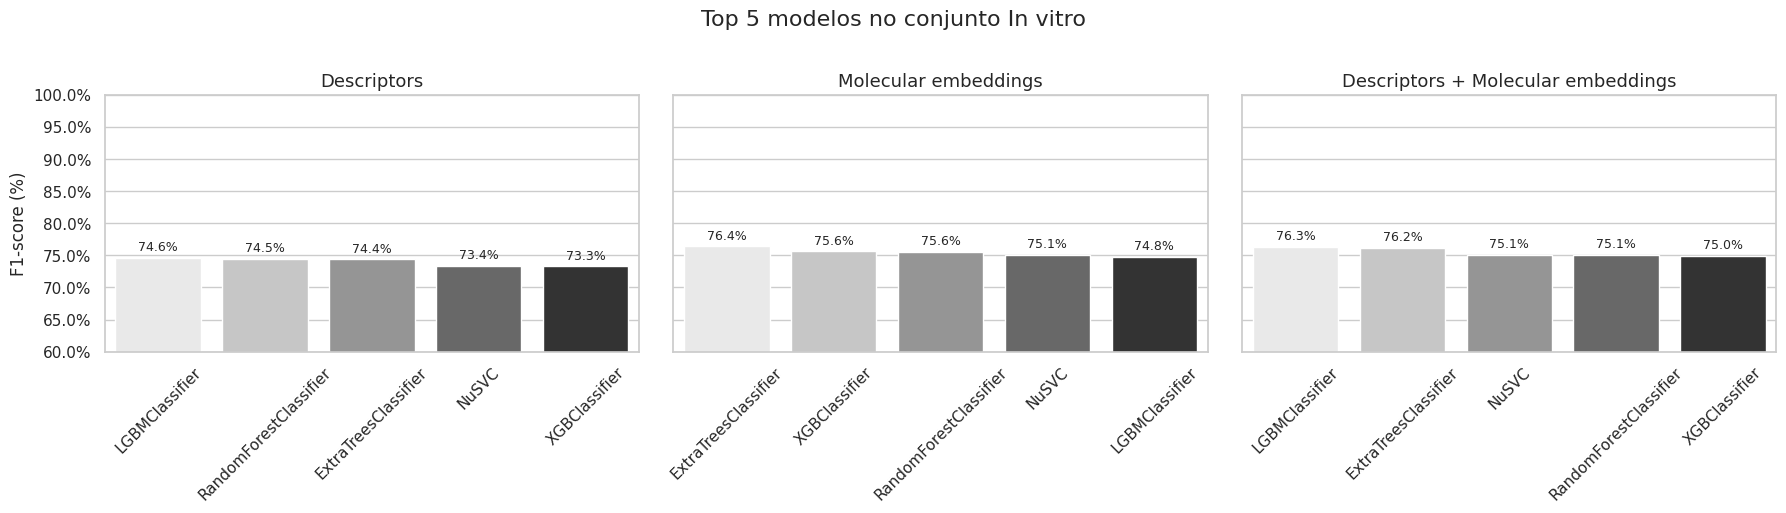

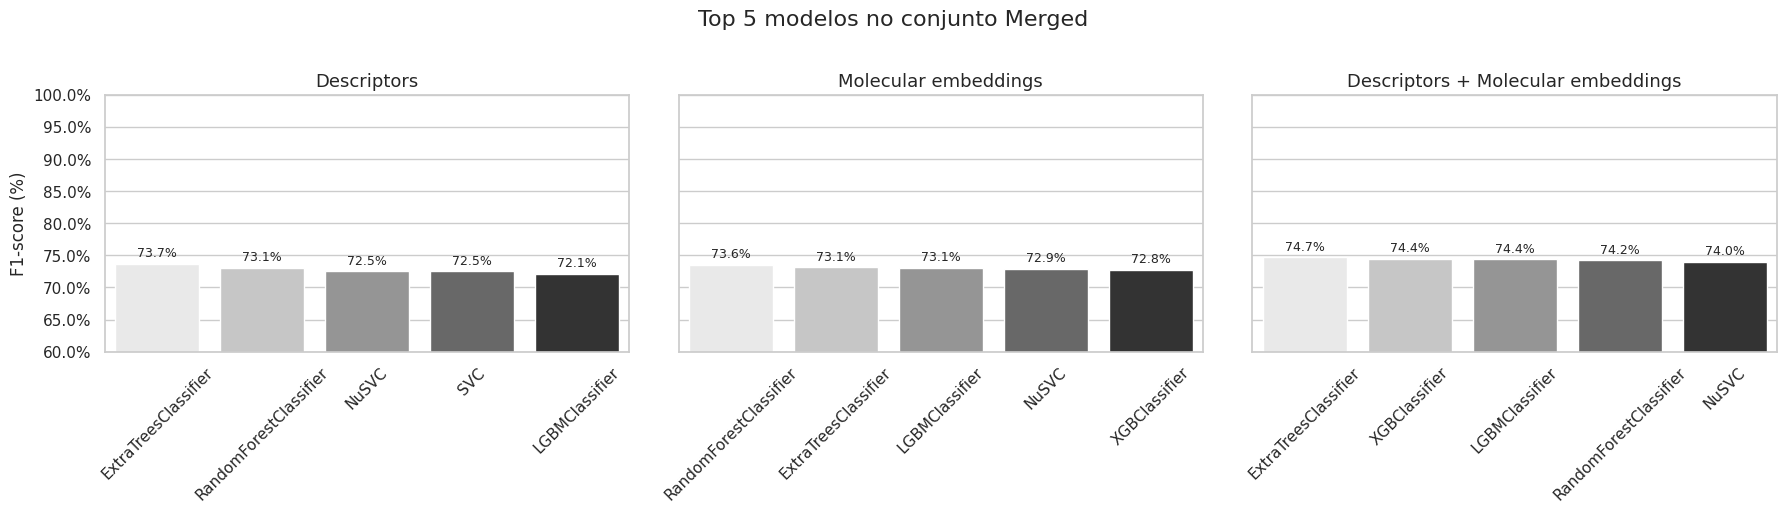

In [44]:
# Ajustar erro: verificar se há legenda antes de tentar removê-la

def plot_grouped_by_dataset_fixed_y_safe(df, conjunto):
    reps = ["Descriptors", "Molecular embeddings", "Descriptors + Molecular embeddings"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle(f"Top 5 modelos no conjunto {conjunto}", fontsize=16, y=1.02)

    for ax, rep in zip(axes, reps):
        df_filtered = df[
            (df["Conjunto"] == conjunto) &
            (df["Representação"] == rep)
        ]

        sns.barplot(
            data=df_filtered,
            x="Modelo",
            y="F1-score",
            hue="Modelo",
            palette="Greys",
            dodge=False,
            ax=ax
        )

        ax.set_title(rep, fontsize=13)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
        ax.set_ylim(0.6, 1.0)
        ax.set_xlabel("")
        ax.set_ylabel("F1-score (%)" if ax == axes[0] else "")
        ax.tick_params(axis='x', rotation=45)

        legend = ax.get_legend()
        if legend:
            legend.remove()

        for container in ax.containers:
            ax.bar_label(
                container,
                labels=[f"{v*100:.1f}%" for v in container.datavalues],
                label_type='edge',
                fontsize=9,
                padding=3
            )

    plt.tight_layout()
    plt.show()

# Replotar com segurança
for conjunto in df_top5_all["Conjunto"].unique():
    plot_grouped_by_dataset_fixed_y_safe(df_top5_all, conjunto)


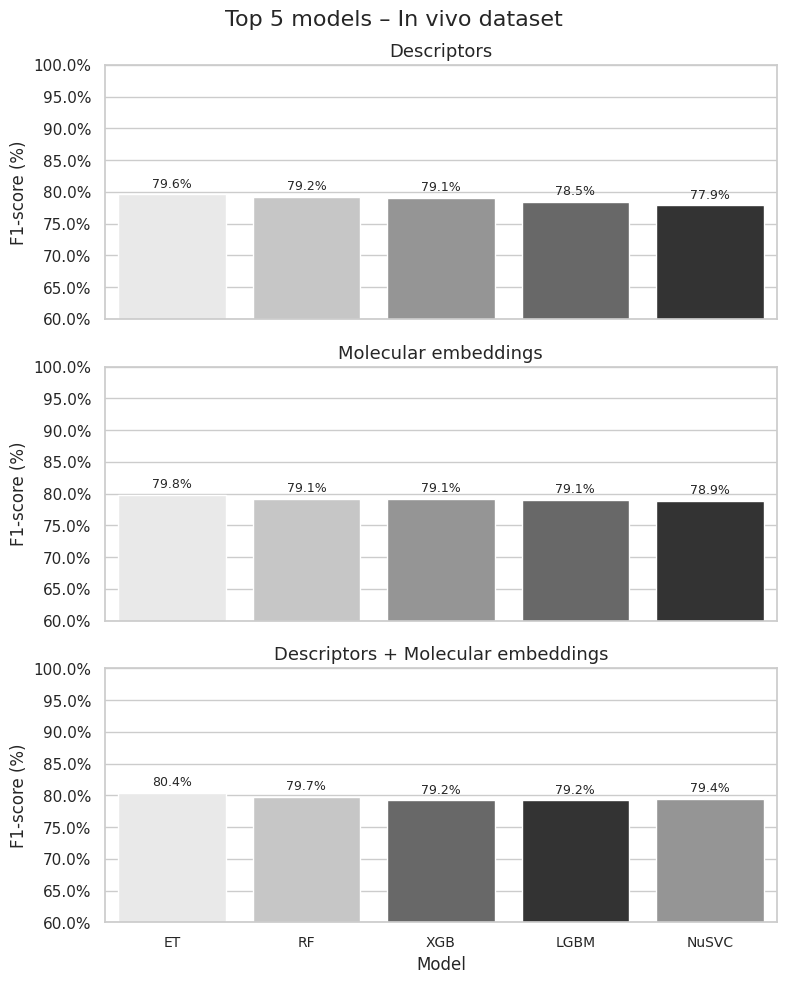

In [53]:
# Ajustar título principal para inglês com novo texto
def plot_vertical_by_dataset_alinhado(df, conjunto):
    reps = ["Descriptors", "Molecular embeddings", "Descriptors + Molecular embeddings"]

    # Novo título em inglês
    title_map = {
        "In vivo": "Top 5 models – In vivo dataset",
        "In vitro": "Top 5 models – In vitro dataset",
        "Merged": "Top 5 models – Merged dataset"
    }

    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    fig.suptitle(title_map.get(conjunto, conjunto), fontsize=16, y=0.98)  # novo título

    for ax, rep in zip(axes, reps):
        df_filtered = df[
            (df["Conjunto"] == conjunto) &
            (df["Representação"] == rep)
        ].copy()

        # Abreviações
        df_filtered["Modelo"] = df_filtered["Modelo"].map(abreviacoes).fillna(df_filtered["Modelo"])

        sns.barplot(
            data=df_filtered,
            x="Modelo",
            y="F1-score",
            hue="Modelo",
            palette="Greys",
            dodge=False,
            ax=ax
        )

        ax.set_title(rep, fontsize=13)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
        ax.set_ylim(0.6, 1.0)
        ax.set_ylabel("F1-score (%)")
        ax.set_xlabel("")
        ax.tick_params(axis='x', labelsize=10, rotation=0)

        legend = ax.get_legend()
        if legend:
            legend.remove()

        for container in ax.containers:
            ax.bar_label(
                container,
                labels=[f"{v*100:.1f}%" for v in container.datavalues],
                label_type='edge',
                fontsize=9,
                padding=3
            )

    axes[-1].set_xlabel("Model")
    plt.tight_layout()
    plt.show()


# Replotar apenas o conjunto "In vivo" com título ajustado
plot_vertical_by_dataset_alinhado(df_top5_all, "In vivo")


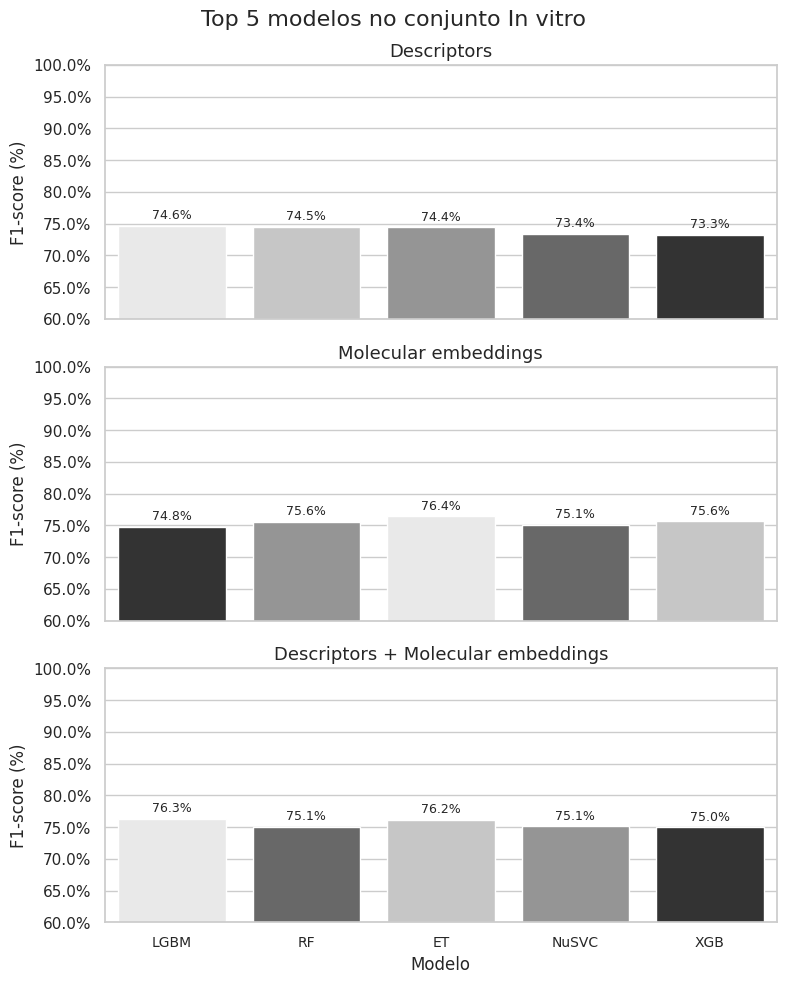

In [48]:
# Replotar apenas o conjunto "In vivo" com título ajustado
plot_vertical_by_dataset_alinhado(df_top5_all, "In vitro")

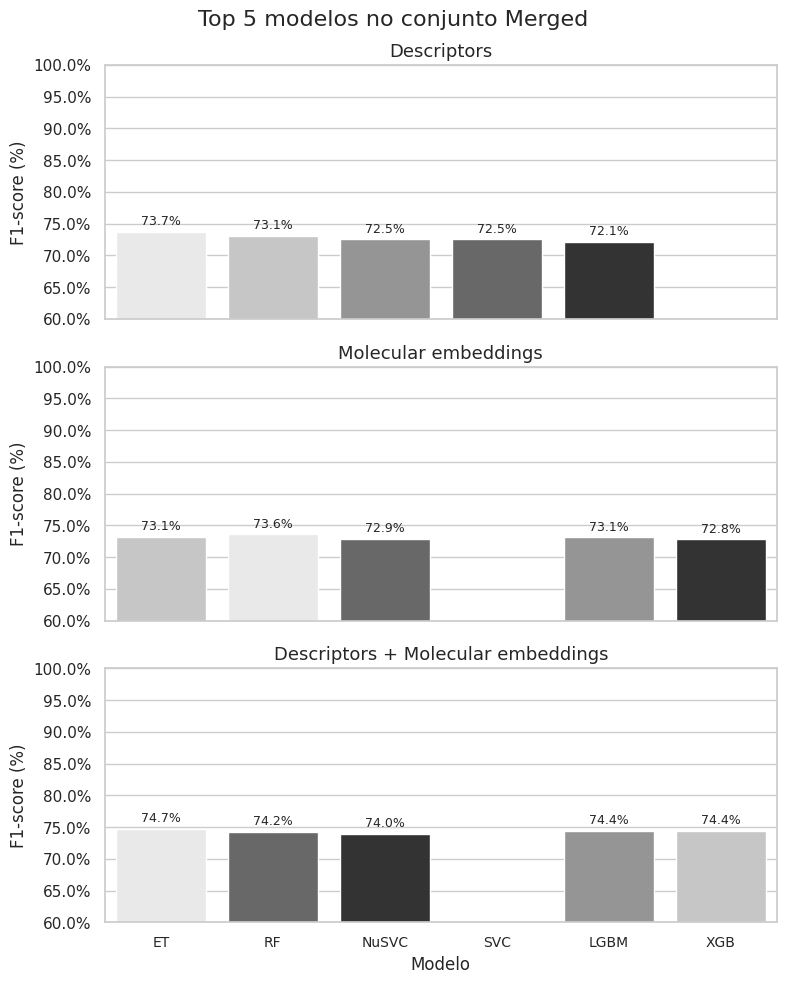

In [49]:
# Replotar apenas o conjunto "In vivo" com título ajustado
plot_vertical_by_dataset_alinhado(df_top5_all, "Merged")